# Function for GPR Plot
## Example Parameter: Global Avg Leaf Carbon Nitrogen Ratio (LNC) 
## Example Variable:  Global Avg Leaf Nitrogen Concentration (leafcn)
#### Author: Sofia Ingersoll

#### Brief Overview 

The kernel configuration is under heavy construction in the `gpr_kernel_exploration.ipnb` located in here `GaiaFuture/Script/ML/gaussian`. The one in this notebook is performing extermely poorly and I am having difficulties applying the same plotting mechanism I used on the 1 vs 1.

Directly beneath the error message in this notebook is a plot output of my previously working method. There is a bug relating to the sequence of the points being plotted. The patterned appeared to be juming back and forth. I tried to address this by defining `x_pred = x_test.linspace(0,1,50)`, but I am haven't fully debugged it yet.


In [6]:
# moved the libraries that were here into ml_utils.py because they're essential
# xarray is required to run the utils import line
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
# import libraries & data pre-processing functions from utils.py
from ml_utils import *

In [4]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 40)

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34533 instead
  warnings.warn(


In [5]:
# apply peer2peer network communication across multiple devices
client.cluster

PBSCluster(8a442c92, 'tcp://128.117.208.52:46371', workers=30, threads=30, memory=279.30 GiB)

Prepare the data for GPR, including selecting the target variable and the parameters as features.

Split the data into training and testing sets.

Define a grid of hyperparameters for the GPR model.

Perform grid search cross-validation to find the best hyperparameters.

Fit the GPR model using the best hyperparameters on the training data.

Generate predictions and confidence intervals for each variable using the trained model.

Plot the results, including the observed data, predicted values, and confidence intervals.

### Loading the Data

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----     load data stored in casper     ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#------- Parameter Data---------
# x variable data for plotting
param_avg = params

# Reshape param_avg into a numpy array with shape (500, 32)
param_values = param_avg.to_array().values

# each row represents a simulation and each column represents a parameter
param_reshaped = param_values.reshape(500, -1)

# confirm output is (500, 32)
param_reshaped.shape

(500, 32)

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    variable wrangling     ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
da = subset_var_cluster('LNC')

In [9]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    variable wrangling     ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# only runs once, then outputs an error -- add a cute message to shorten warning
var_avg = wrangle_var_cluster(da)

# reshape for splitting
var_reshaped = var_avg.values.reshape(-1, 1)

# what's going on here? let's check the shape!
var_reshaped.shape

# for dashboard, include line to save output as a file to call later
# ifelse statement to either create file or read in

(500, 1)

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
x_train, x_test, y_train, y_test = train_test_split(param_reshaped,
                                                    var_reshaped,
                                                    test_size=0.1,
                                                    random_state=0)

In [6]:
for p in params.data_vars:
    print(p)

FUN_fracfixers
KCN
a_fix
crit_dayl
d_max
fff
froot_leaf
fstor2tran
grperc
jmaxb0
jmaxb1
kcha
kmax
krmax
leaf_long
leafcn
lmr_intercept_atkin
lmrha
lmrhd
medlynintercept
medlynslope
nstem
psi50
q10_mr
slatop
soilpsi_off
stem_leaf
sucsat_sf
theta_cj
tpu25ratio
tpuse_sf
wc2wjb0


In [12]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    1st Set up Tune Grid      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define a grid of hyperparameters for the GPR model

tune_grid = {
    "kernel": [1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)],
    # Add more kernel configurations as needed
}

In [13]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Cross Validation        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Perform grid search cross-validation to find the best hyperparameters
gpr = GaussianProcessRegressor(n_restarts_optimizer=20)

grid_search = GridSearchCV(gpr, tune_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(x_train, y_train)


/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GridSearchCV(cv=5, estimator=GaussianProcessRegressor(n_restarts_optimizer=20),
             param_grid={'kernel': [1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05)]},
             scoring='neg_mean_squared_error')

In [14]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Collect Metrics         ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the best hyperparameters
best_kernel = grid_search.best_params_['kernel']

In [15]:
best_kernel

1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05)

In [16]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Finalize Workflow       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Fit the GPR model using the best hyperparameters on the training data
gpr_best = GaussianProcessRegressor(kernel=best_kernel)
gpr_best.fit(x_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05))

In [18]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Fit Model            ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   
 # standard 0:1, set constant
x_pred = np.linspace(0,1,50)

# Generate predictions and confidence intervals for each variable using the trained model
y_pred, sigma = gpr_best.predict(x_test, return_std=True)     # to be included once upper portion of workflow optimized

### Metric Evaluation
##### RMSE & R2
The model is performing worse than a horizontal line, definitely needs kernel adjustments

In [19]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----        Evaluate Model         ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# get accuracy of testing prediction, rmse & r2
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

Root Mean Squared Error: 0.19676150495896885
R² Score: -0.02629333353556773


In [22]:
x_test.shape

(50, 32)

In [23]:
y_test.shape

(50, 1)

ValueError: x and y must be the same size

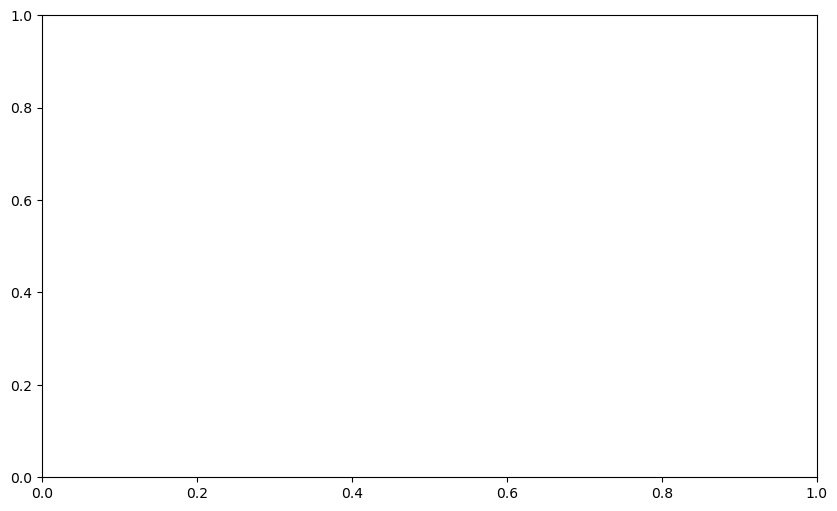

In [21]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----        Visual Model Fit      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plot the results

plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test, color='#62c900ff', label='Observed data')
plt.plot(x_pred, y_pred, color='#134611', label='GPR Prediction')
plt.fill_between(x_test.flatten(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.5, color='#9d6b53', label = '95% Confidence Interval')
plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
plt.ylabel('Variable: Leaf Nitrogen Concentration')
plt.title('Gaussian Process Regression Uncertainty Estimation')
plt.legend()
plt.show()

### 2nd attempt
This has errors in the x_pred.linspace.

We want it to plot sequentially rather than the back and forth that's currently happening

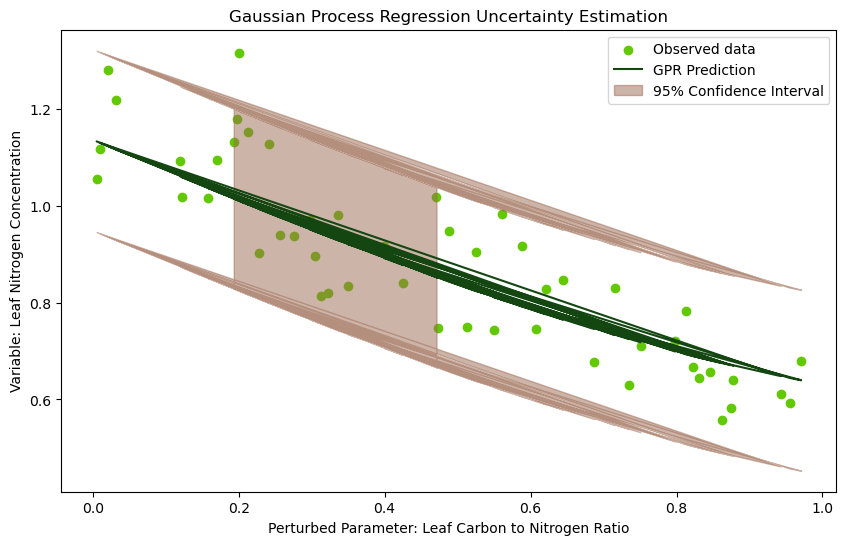

In [56]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----        Visual Model Fit      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test, color='#62c900ff', label='Observed data')
plt.plot(x_test, y_pred, color='#134611', label='GPR Prediction')
# applying z-score for 95% CI
plt.fill_between(x_test.flatten(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.5, color='#9d6b53', label = '95% Confidence Interval')
plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
plt.ylabel('Variable: Leaf Nitrogen Concentration')
plt.title('Gaussian Process Regression Uncertainty Estimation')
plt.legend()
plt.show()

In [50]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Set up Tune Grid         ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define a grid of hyperparameters for the GPR model
tune_grid = {
    "kernel": [1.0 * RBF(length_scale=1.0)],
    # Add more kernel configurations as needed
}

In [51]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Cross Validation        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Perform grid search cross-validation to find the best hyperparameters
gpr = GaussianProcessRegressor(n_restarts_optimizer=20)

grid_search = GridSearchCV(gpr, tune_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=GaussianProcessRegressor(n_restarts_optimizer=20),
             param_grid={'kernel': [1**2 * RBF(length_scale=1)]},
             scoring='neg_mean_squared_error')

In [52]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Collect Metrics         ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the best hyperparameters
best_kernel = grid_search.best_params_['kernel']

In [53]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Fit Model            ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Generate predictions and confidence intervals for each variable using the trained model
y_pred, sigma = gpr_best.predict(x_test, return_std=True)

### 3rd attempt

In [91]:
# for simplicity's sake, we're going to use the preloaded data rn
leafcn = params['leafcn']

def plot_gpr(param, var):
    '''describe the relationship between the selected variable 
    and parameter(s) over the selected period of time. output a
    best fit line of regression.'''
    # Plotting
    plt.scatter(x=param, y=var, color = '#62c900ff', alpha = 0.8)
    # Set plot labels and title
    plt.xlabel(param)
    plt.ylabel(var)
    plt.title('2005-2010 Global Average')

    # Set boundaries

    # Gaussian Process Regression
    kernel = C(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
    x = param.reshape(-1, 1)
    y = var
    gp.fit(x, y)
    x_pred = np.linspace(0, 1, 100).reshape(-1, 1)
    y_pred, sigma = gp.predict(x_pred, return_std=True)
    plt.plot(x_pred, y_pred, '#134611', label='Gaussian Process Regression')
    plt.fill_between(x_pred.flatten(), y_pred - sigma, y_pred + sigma, alpha=0.2, color='#9d6b53')

    # Show legend with confidence interval
    plt.legend(loc='upper right',  bbox_to_anchor=(1, 1), labels=['Data', 'Gaussian Process Regression', '95% Confidence Interval'])


    # Show the plot
    plt.show()

In [ ]:
plot_gpr(leafcn, lnc)

Task exception was never retrieved
future: <Task finished name='Task-823269' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-823132' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-823609' c

Unexpected exception formatting exception. Falling back to standard exception


Task exception was never retrieved
future: <Task finished name='Task-823515' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-823612' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-823618' c

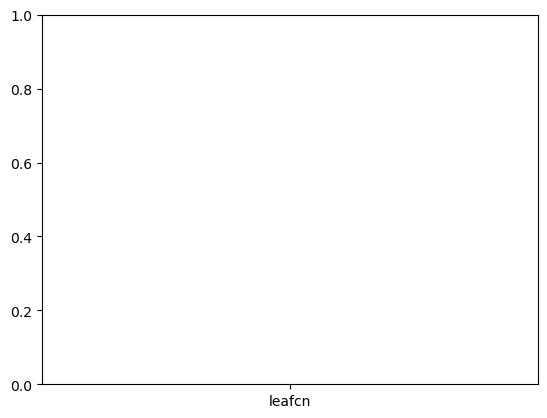

Task exception was never retrieved
future: <Task finished name='Task-823577' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-823627' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-823590' c

In [95]:
# Example usage:
plot_gpr('leafcn', lnc)